In [1]:
import numpy as np
from astropy.io import fits
from scipy.optimize import curve_fit
import os
import glob
from pylab import *
from math import e
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.ndimage import rotate
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
#path1  = "/Users/anh5866/Desktop/Coding/OGRE/collimated_beam/temp_fits/1-833-stability*11*.fits"
#path1 = "/Users/anh5866/Desktop/Coding/OGRE/collimated_beam/20250917_fits/*.fits"
path1 = "/Users/anh5866/Desktop/Coding/OGRE/collimated_beam/morning5237_fits/*.fits"

fits_list = glob.glob(path1)
fits_list = np.sort(fits_list,kind='standardsort')


#sorted_list = sorted(fits_list, key=lambda x: int(re.search(r'stability(\d+)', x).group(1)))

#np.set_printoptions(threshold=np.inf)  # show entire array, no truncation


# only keep files that match "stability...123"
#fits_list = [f for f in fits_list if re.search(r'stability(\d+)', f)]

#sorted_list = sorted(fits_list, key=lambda x: int(re.search(r'stability(\d+)', x).group(1)))

#for f in sorted_list:
#    print(f)

print(fits_list)
print(len(fits_list))

['/Users/anh5866/Desktop/Coding/OGRE/collimated_beam/morning5237_fits/morning0001 25-09-22 09-31-41.fits'
 '/Users/anh5866/Desktop/Coding/OGRE/collimated_beam/morning5237_fits/morning0002 25-09-22 09-31-41.fits'
 '/Users/anh5866/Desktop/Coding/OGRE/collimated_beam/morning5237_fits/morning0003 25-09-22 09-31-41.fits'
 ...
 '/Users/anh5866/Desktop/Coding/OGRE/collimated_beam/morning5237_fits/morning9443 25-09-22 09-34-40.fits'
 '/Users/anh5866/Desktop/Coding/OGRE/collimated_beam/morning5237_fits/morning9444 25-09-22 09-34-40.fits'
 '/Users/anh5866/Desktop/Coding/OGRE/collimated_beam/morning5237_fits/morning9445 25-09-22 09-34-40.fits']
9445


In [3]:

'''
def openfits(path):
    
    hdu = fits.open(path)
    data = hdu[0].data    #data
    hdr = hdu[0].header    # headers
    
    #image_data = fits.getdata(path, ext=0)
    #image_data = np.flip(np.transpose(image_data), axis=1) #flip data by 90 degrees
    #image_data = np.flip(image_data, axis=(0, 1)) #flip data by 180 degrees
    
    #data = np.flip(np.transpose(data), axis=1) #flip data by 90 degrees
    data = np.flip(data, axis=(0, 1)) #flip data by 180 degrees
    
    image_data = data
    
    shape = image_data.shape #shape
    
    return hdu, data, hdr, image_data, shape
    
    '''

#use with to close file 

def openfits(path):
    with fits.open(path) as hdu:
        data = hdu[0].data    # numpy array (lazy loaded)
        hdr  = hdu[0].header  # header
        
        # Flip/transform the data
        data = np.flip(data, axis=(0, 1)) 
        
        image_data = data.copy()  # force load into memory
        shape = image_data.shape
    
    return None, image_data, hdr, image_data, shape

In [4]:
hdu = []
data = []
hdr = []
image_data = []
shape = []

for fits_file in fits_list:
    hdu_temp, data_temp, hdr_temp, image_data_temp, shape_temp = openfits(fits_file)
    
    #data_temp = data_temp[0, :, :]
    
    hdu.append(hdu_temp)
    data.append(data_temp)
    hdr.append(hdr_temp)
    image_data.append(image_data_temp)
    shape.append(shape_temp)

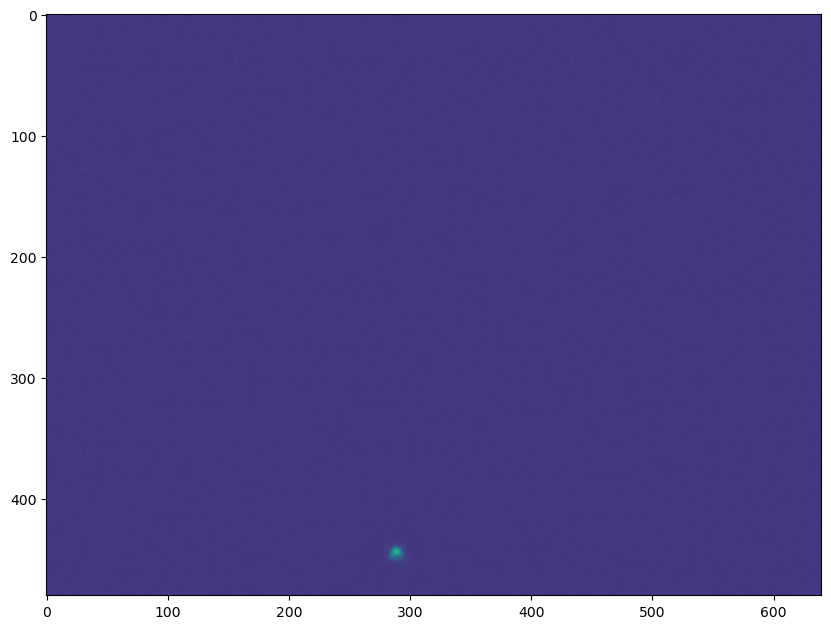

In [5]:
plt.figure(figsize=(10,10))
plt.imshow(data[0], cmap='viridis', vmin = 0, vmax = 100)
#plt.title("title", fontsize=20)
#plt.plot(sum_dat)
#cbar = plt.colorbar()
#cbar.set_label('Ec', fontsize=15)
#plt.colorbar()

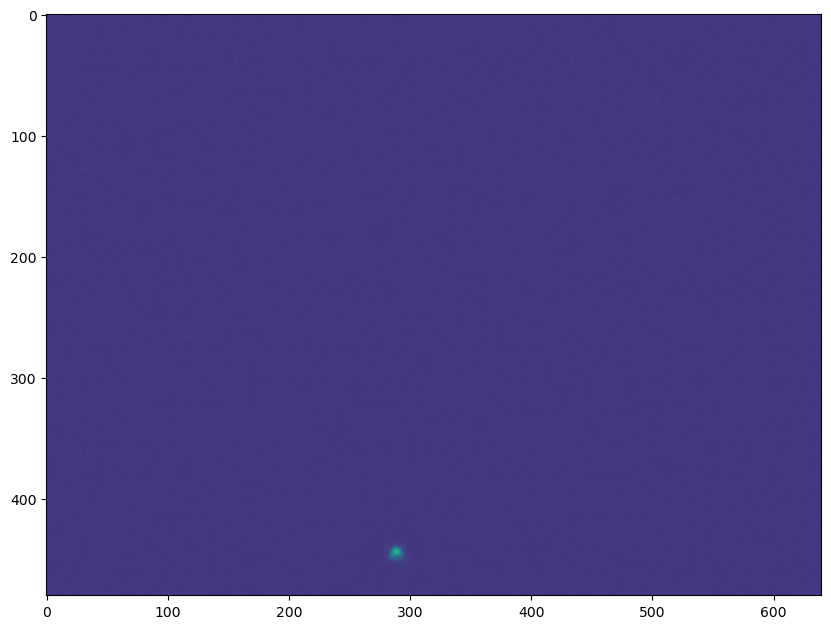

In [6]:
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(data[0], cmap='viridis', vmin=0, vmax=100)

def update(frame):
    im.set_array(data[frame])
    return [im]

#ani = animation.FuncAnimation(fig, update, frames=len(data), interval=200, blit=True)

# show inline in notebook
#HTML(ani.to_jshtml())


In [7]:
print(len(data[0][0]))
print(len(data[0]))
print(data[0].shape)

640
480
(480, 640)


In [8]:
profiles_x = []
profiles_y = []

for img in data:
    # collapse along y (rows); psf along x
    profiles_x.append(np.sum(img, axis=0))

    # collapse along x (columns); psf along y
    profiles_y.append(np.sum(img, axis=1))

profiles_x = np.array(profiles_x) 
profiles_y = np.array(profiles_y)  


Animation size has reached 21207661 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


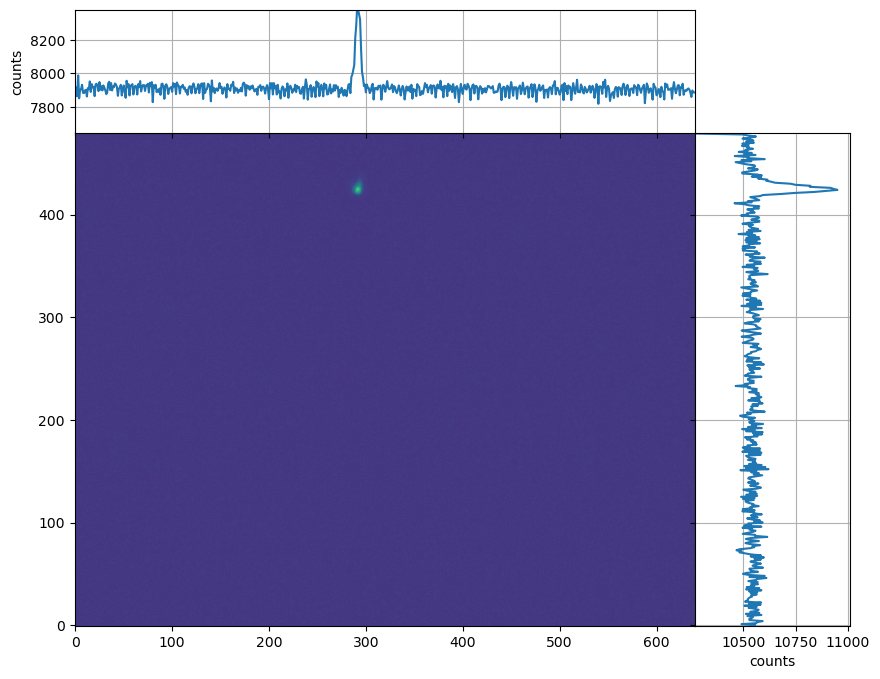

In [9]:
fig = plt.figure(figsize=(10,8))

#2x2 grid equal sizes
gs = fig.add_gridspec(2, 2, width_ratios=[4,1], height_ratios=[1,4], wspace=0.0, hspace=0.0)

ax_img = fig.add_subplot(gs[1,0])
ax_x   = fig.add_subplot(gs[0,0], sharex=ax_img)  # x (top)
ax_y   = fig.add_subplot(gs[1,1], sharey=ax_img)  # y (right)

#hide the empty top-right cell
fig.add_subplot(gs[0,1]).axis("off")

#primary image
im = ax_img.imshow(data[0], cmap="viridis", origin="lower", vmin=0, vmax=100, aspect="auto")

#profiles
profile_x = np.sum(data[0], axis=0)
profile_y = np.sum(data[0], axis=1)

line_x, = ax_x.plot(np.arange(data[0].shape[1]), profile_x)          # x psf
line_y, = ax_y.plot(profile_y, np.arange(data[0].shape[0]))          # y psf

#sync axes so they align
ax_x.set_xlim(ax_img.get_xlim())
ax_y.set_ylim(ax_img.get_ylim())

#ticks
ax_x.tick_params(labelbottom=False)
ax_y.tick_params(labelleft=False)

ax_x.set_ylabel("counts")
ax_y.set_xlabel("counts")

ax_x.grid()
ax_y.grid()


# compute global maxima across ALL frames
max_x = max(np.sum(img, axis=0).max() for img in data)
max_y = max(np.sum(img, axis=1).max() for img in data)

min_x = max(np.sum(img, axis=0).min() for img in data)
min_y = max(np.sum(img, axis=1).min() for img in data)

ax_x.set_ylim(min_x-200, max_x-200)   # add headroom
ax_y.set_xlim(min_y-200, max_y)

def update(frame):
    img = data[frame]
    im.set_array(img)

    profile_x = np.sum(img, axis=0)
    profile_y = np.sum(img, axis=1)

    line_x.set_ydata(profile_x)
    line_y.set_xdata(profile_y)
    return [im, line_x, line_y]

ani = animation.FuncAnimation(fig, update, frames=len(data), interval=200, blit=True)

HTML(ani.to_jshtml())

#comment out below to not save video 
Writer = animation.writers['ffmpeg']
writer = Writer(fps=20, metadata=dict(artist='Me'), bitrate=1800)

ani.save("psf_movie.mp4", writer=writer)


In [10]:
# example fit for just first frame


def gaussian(x, amp, mu, sigma, offset):
    return amp * np.exp(-0.5 * ((x - mu)/sigma)**2) + offset


img = data[0]

profile_x = np.sum(img, axis=0)
profile_y = np.sum(img, axis=1)

x_vals = np.arange(profile_x.size)
p0_x = [profile_x.max(), profile_x.argmax(), 5, np.median(profile_x)]  # initial guess
popt_x, pcov_x = curve_fit(gaussian, x_vals, profile_x, p0=p0_x)

y_vals = np.arange(profile_y.size)
p0_y = [profile_y.max(), profile_y.argmax(), 5, np.median(profile_y)]
popt_y, pcov_y = curve_fit(gaussian, y_vals, profile_y, p0=p0_y)

# popt_x = [amp, mu, sigma, offset] for x-profile
# popt_y = [amp, mu, sigma, offset] for y-profile

# Generate smooth fit curves
x_fit = gaussian(x_vals, *popt_x)
y_fit = gaussian(y_vals, *popt_y)

print("X fit:", popt_x)
print("Y fit:", popt_y)


X fit: [3.99811604e+02 2.89153018e+02 3.28448775e+00 7.86818180e+03]
Y fit: [3.82909983e+02 4.44759123e+02 2.95558580e+00 1.04918566e+04]


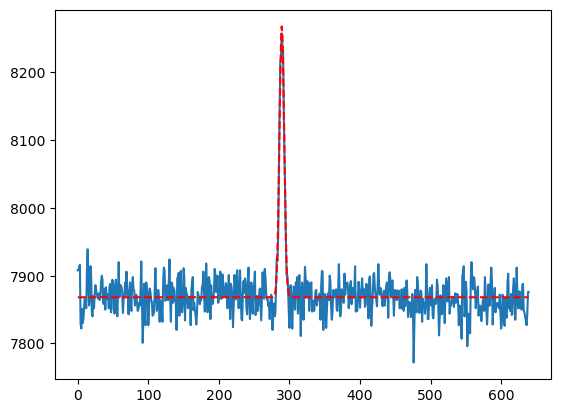

In [11]:
plot(np.arange(data[0].shape[1]), profile_x) 
plot(x_vals, x_fit, 'r--', label="Gaussian fit")

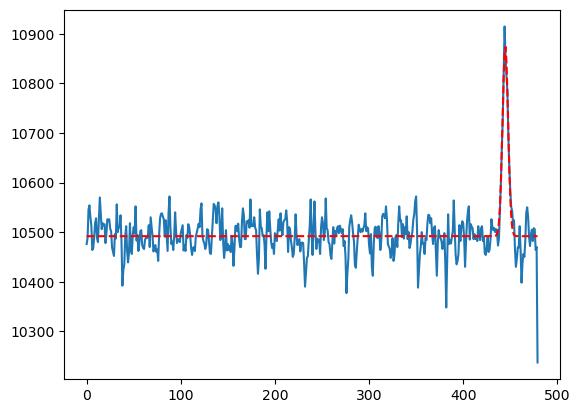

In [12]:
plot(np.arange(data[0].shape[0]), profile_y) 
plot(y_vals, y_fit, 'r--', label="Gaussian fit")

In [13]:
def gaussian(x, amp, mu, sigma, offset):
    return amp * np.exp(-0.5 * ((x - mu)/sigma)**2) + offset

#initialize
amps_x, mus_x, sigmas_x, offsets_x = [], [], [], []
amps_y, mus_y, sigmas_y, offsets_y = [], [], [], []

for img in data:
    # collapse
    profile_x = np.sum(img, axis=0)
    profile_y = np.sum(img, axis=1)

    #fit x
    x_vals = np.arange(profile_x.size)
    p0_x = [profile_x.max(), profile_x.argmax(), 5, np.median(profile_x)]
    try:
        popt_x, _ = curve_fit(gaussian, x_vals, profile_x, p0=p0_x)
    except RuntimeError:
        popt_x = [np.nan]*4

    amps_x.append(popt_x[0])
    mus_x.append(popt_x[1])
    sigmas_x.append(popt_x[2])
    offsets_x.append(popt_x[3])

    #fit y
    y_vals = np.arange(profile_y.size)
    p0_y = [profile_y.max(), profile_y.argmax(), 5, np.median(profile_y)]
    try:
        popt_y, _ = curve_fit(gaussian, y_vals, profile_y, p0=p0_y)
    except RuntimeError:
        popt_y = [np.nan]*4

    amps_y.append(popt_y[0])
    mus_y.append(popt_y[1])
    sigmas_y.append(popt_y[2])
    offsets_y.append(popt_y[3])

#to np.array
amps_x = np.array(amps_x)
mus_x = np.array(mus_x)
sigmas_x = np.array(sigmas_x)
offsets_x = np.array(offsets_x)

amps_y = np.array(amps_y)
mus_y = np.array(mus_y)
sigmas_y = np.array(sigmas_y)
offsets_y = np.array(offsets_y)


/Users/anh5866/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [14]:
#need to add cut to data for bad fits and NANs 

def filter_fits(amps_x, mus_x, sigmas_x, offsets_x,
                amps_y, mus_y, sigmas_y, offsets_y,
                fwhm_min, fwhm_max):
    
    fwhm_x = 2.355 * sigmas_x
    fwhm_y = 2.355 * sigmas_y

    #mask for NANs & infs
    finite_mask = (
        np.isfinite(amps_x) & np.isfinite(mus_x) & np.isfinite(sigmas_x) & np.isfinite(offsets_x) &
        np.isfinite(amps_y) & np.isfinite(mus_y) & np.isfinite(sigmas_y) & np.isfinite(offsets_y)
    )

    #mask for reasonable FWHM
    fwhm_mask = (
        (fwhm_x > fwhm_min) & (fwhm_x < fwhm_max) &
        (fwhm_y > fwhm_min) & (fwhm_y < fwhm_max)
    )

    #both 
    mask = finite_mask & fwhm_mask

    return (amps_x[mask], mus_x[mask], sigmas_x[mask], offsets_x[mask],
            amps_y[mask], mus_y[mask], sigmas_y[mask], offsets_y[mask],
            fwhm_x[mask], fwhm_y[mask], mask)


In [15]:
filtered = filter_fits(amps_x, mus_x, sigmas_x, offsets_x,
                       amps_y, mus_y, sigmas_y, offsets_y,
                       fwhm_min=1, fwhm_max=1000)

filtered

(array([399.81160358, 452.47908154, 416.78595453, ..., 506.57130358,
        503.73428008, 499.24123928]),
 array([289.15301764, 289.38335887, 290.62845851, ..., 292.56455919,
        291.88005801, 291.81533287]),
 array([3.28448775, 3.23830419, 3.28694411, ..., 2.78827243, 2.73680725,
        2.68495135]),
 array([7868.18180487, 7884.46113368, 7880.10318631, ..., 7890.05389192,
        7887.81922349, 7905.98440484]),
 array([382.90998281, 410.47219918, 368.5180738 , ..., 397.6836939 ,
        401.63749165, 388.25107264]),
 array([444.75912347, 455.40152355, 440.84079521, ..., 464.76819647,
        452.94404828, 425.11895869]),
 array([2.9555858 , 3.63237778, 3.55482603, ..., 3.79307537, 3.4977552 ,
        3.66653977]),
 array([10491.85664658, 10512.48050428, 10507.11723486, ...,
        10519.570993  , 10516.95544654, 10540.87858207]),
 array([7.73496866, 7.62620637, 7.74075337, ..., 6.56638158, 6.44518107,
        6.32306043]),
 array([6.96040455, 8.55424967, 8.3716153 , ..., 8.9326

In [16]:
(amps_x_f, mus_x_f, sigmas_x_f, offsets_x_f,
 amps_y_f, mus_y_f, sigmas_y_f, offsets_y_f,
 fwhm_x_f, fwhm_y_f, mask) = filtered

print(len(amps_x_f))
print(len(fwhm_y_f))

9353
9353


In [17]:
#recenter relative to first frame
mu_x_rel = mus_x_f - mus_x_f[0]
mu_y_rel = mus_y_f - mus_y_f[0]

frames = np.arange(len(mu_x_rel))

print(mu_x_rel)
print(mu_y_rel)

[0.         0.23034124 1.47544087 ... 3.41154155 2.72704037 2.66231523]
[  0.          10.64240008  -3.91832825 ...  20.009073     8.18492481
 -19.64016477]


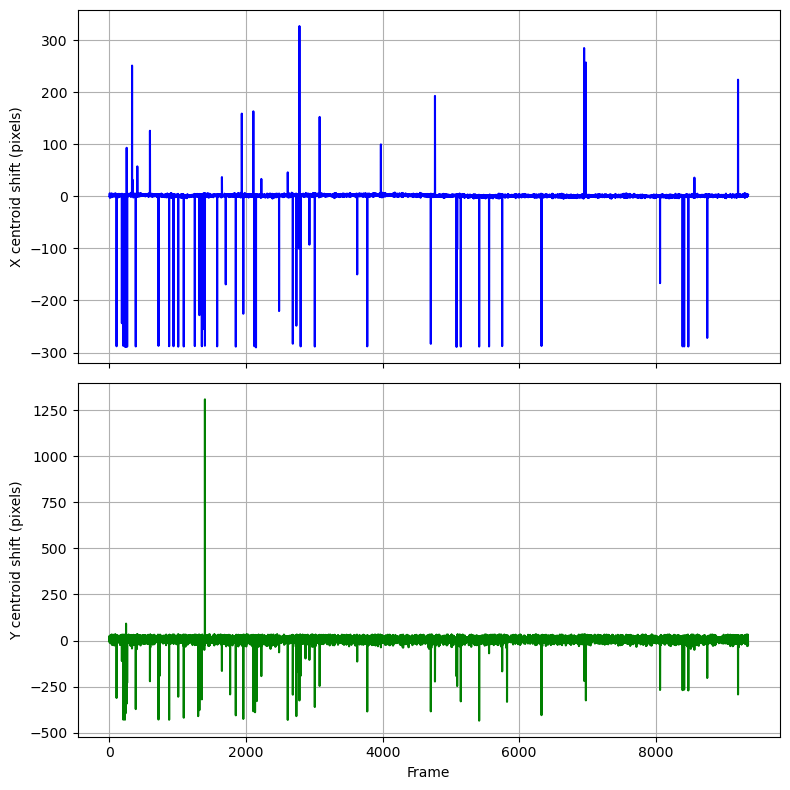

In [18]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

axs[0].plot(frames, mu_x_rel, color='blue')
axs[0].set_ylabel("X centroid shift (pixels)")
#axs[0].set_title("X centroid over time")
axs[0].grid(True)

axs[1].plot(frames, mu_y_rel, color='green')
axs[1].set_xlabel("Frame")
axs[1].set_ylabel("Y centroid shift (pixels)")
#axs[1].set_title("Y centroid over time")
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [19]:
# Compute FWHM
FWHM_factor = 2 * np.sqrt(2 * np.log(2))  # ~2.35482
FWHM_x = sigmas_x_f * FWHM_factor
FWHM_y = sigmas_y_f * FWHM_factor

frames = np.arange(len(FWHM_x))

print(FWHM_x)
print(FWHM_y)

[7.7343776  7.62562362 7.74016187 ... 6.56587982 6.44468857 6.32257726]
[6.95987268 8.553596   8.37097559 ... 8.93200991 8.23658406 8.63404136]


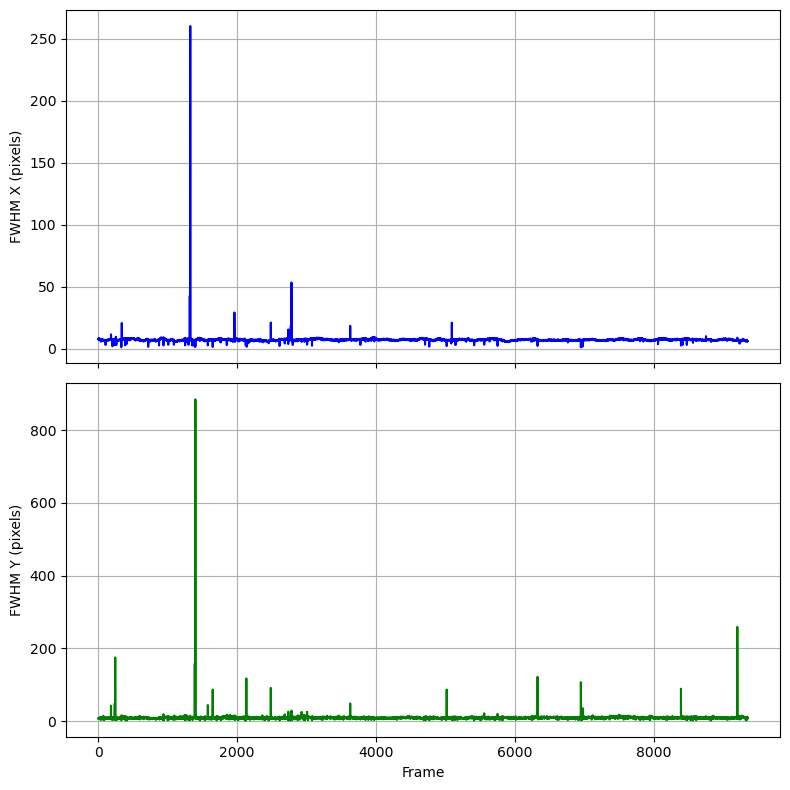

In [20]:
# Plot X and Y FWHM separately
fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# X FWHM
axs[0].plot(frames, FWHM_x, color='blue')
axs[0].set_ylabel("FWHM X (pixels)")
#axs[0].set_title("X FWHM over frames")
axs[0].grid(True)

# Y FWHM
axs[1].plot(frames, FWHM_y, color='green')
axs[1].set_xlabel("Frame")
axs[1].set_ylabel("FWHM Y (pixels)")
#axs[1].set_title("Y FWHM over frames")
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [21]:
np.where(FWHM_y>200)

(array([1398, 9205]),)

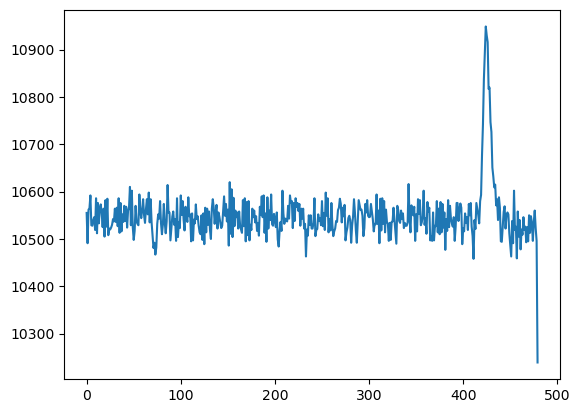

In [22]:
plot(np.arange(data[1418].shape[0]), profile_y) 

In [23]:
print(np.mean(mu_x_rel))
print(np.mean(mu_y_rel))
print(np.std(mu_x_rel))
print(np.std(mu_y_rel))

0.25078782199652805
3.316233172454707
20.515349337072024
31.71970403428472


In [24]:
print(np.mean(FWHM_x))
print(np.mean(FWHM_y))
print(np.std(FWHM_x))
print(np.std(FWHM_y))

7.350266228908089
9.00179656624967
2.788205192697156
10.206896572803112


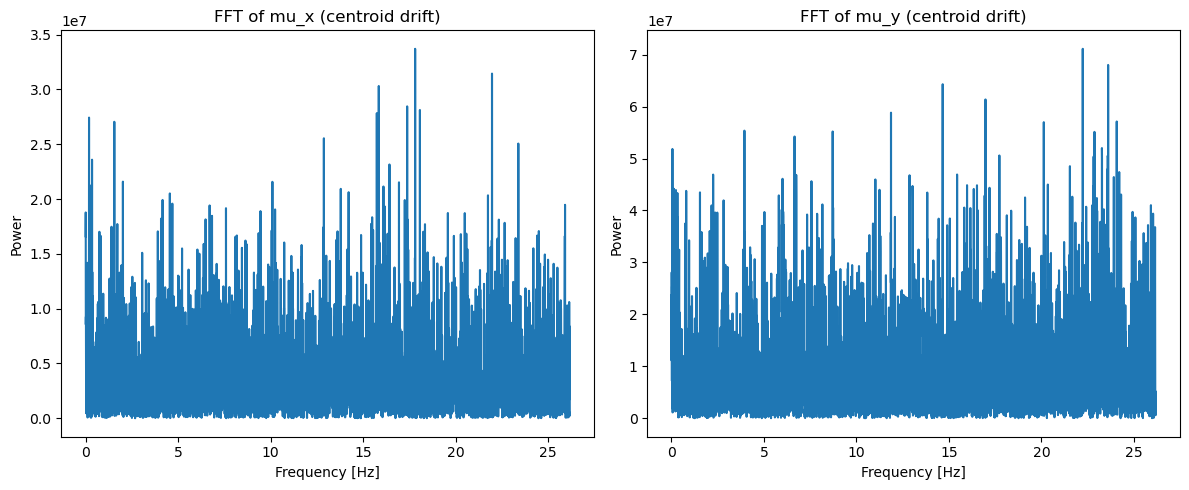

In [25]:
frame_rate = 52.37   # Hz (frames per second)
dt = 1.0 / frame_rate
N = len(mu_x_rel)

#compute FFT for x and y
fft_x = np.fft.fft(mu_x_rel - np.mean(mu_x_rel))  # subtract mean to remove DC offset
fft_y = np.fft.fft(mu_y_rel - np.mean(mu_y_rel))

#frequencies corresponding to FFT bins
freqs = np.fft.fftfreq(N, d=dt)

#only positiev freq (real signal) 
pos_mask = freqs > 0
freqs = freqs[pos_mask]
power_x = np.abs(fft_x[pos_mask])**2
power_y = np.abs(fft_y[pos_mask])**2


plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(freqs, power_x)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power")
plt.title("FFT of mu_x (centroid drift)")

plt.subplot(1,2,2)
plt.plot(freqs, power_y)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power")
plt.title("FFT of mu_y (centroid drift)")

plt.tight_layout()
plt.show()


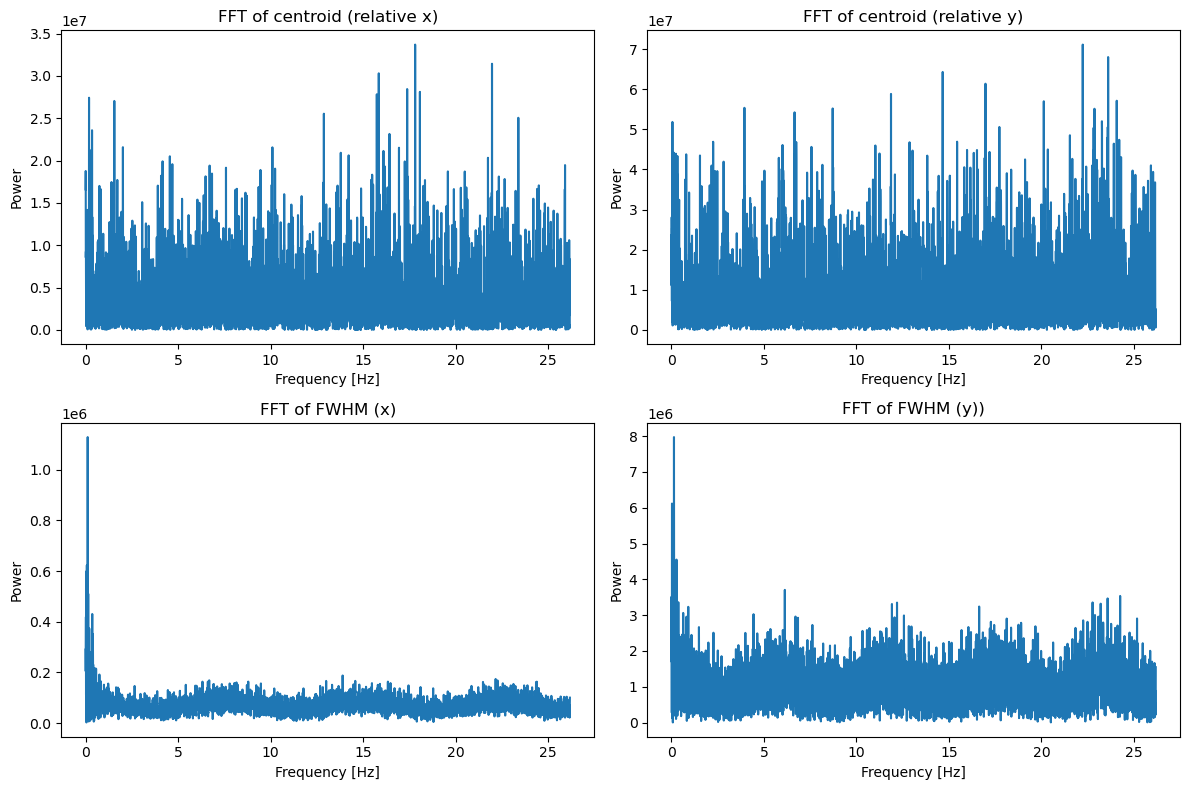

In [26]:
def compute_fft(signal, dt):
    N = len(signal)
    fft_vals = np.fft.fft(signal - np.mean(signal))  # remove DC offset
    freqs = np.fft.fftfreq(N, d=dt)
    mask = freqs > 0
    return freqs[mask], np.abs(fft_vals[mask])**2


frame_rate = 52.37   #hz (frames per second)
dt = 1.0 / frame_rate

#fFTs
freqs_x, power_mu_x   = compute_fft(mu_x_rel, dt)
freqs_y, power_mu_y   = compute_fft(mu_y_rel, dt)
freqs_fx, power_fwhm_x = compute_fft(FWHM_x, dt)
freqs_fy, power_fwhm_y = compute_fft(FWHM_y, dt)


fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0,0].plot(freqs_x, power_mu_x)
axs[0,0].set_title("FFT of centroid (relative x)")
axs[0,0].set_xlabel("Frequency [Hz]")
axs[0,0].set_ylabel("Power")

axs[0,1].plot(freqs_y, power_mu_y)
axs[0,1].set_title("FFT of centroid (relative y)")
axs[0,1].set_xlabel("Frequency [Hz]")
axs[0,1].set_ylabel("Power")

axs[1,0].plot(freqs_fx, power_fwhm_x)
axs[1,0].set_title("FFT of FWHM (x)")
axs[1,0].set_xlabel("Frequency [Hz]")
axs[1,0].set_ylabel("Power")

axs[1,1].plot(freqs_fy, power_fwhm_y)
axs[1,1].set_title("FFT of FWHM (y))")
axs[1,1].set_xlabel("Frequency [Hz]")
axs[1,1].set_ylabel("Power")

plt.tight_layout()
plt.show()
